In [1]:
# Define a flag to check if %cd .. has been run
if 'cd_executed' not in globals():
    %cd ..
    cd_executed = True  # Set the flag to True after the command runs


/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2


In [2]:
from liegroups.numpy import SO3 as SO3_np
import tqdm

from __future__ import absolute_import, division, print_function

import numpy as np
import time
import pdb
import shutil

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter

import json

from utils import *
from kitti_utils import *
from layers import *

import datasets
# import networks
from networks.velo_decoder import VeloDecoder
from networks.gravity_decoder import GravityDecoder
from networks.depth_decoder import DepthDecoder
from networks.resnet_encoder import ResnetEncoder
from ekf import EKFModel
from ekf import proc_vis_covar

from options import MonodepthOptions


import matplotlib.pyplot as plt

import matplotlib.animation as animation


# Metrics
import importlib
from export_gt_depth_trajectory import export_gt_depths_kitti_part2
import cv2

### Standard Functions

In [3]:
class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud
    """
    def __init__(self, batch_size, height, width):
        super(BackprojectDepth, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords),
                                      requires_grad=False)

        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width),
                                 requires_grad=False)

        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1),
                                       requires_grad=False)

    def forward(self, depth, inv_K):
        cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)

        cam_points = depth.view(self.batch_size, 1, -1) * cam_points
        cam_points = torch.cat([cam_points, self.ones], 1)

        return cam_points


class Project3D(nn.Module):
    """Layer which projects 3D points into a camera with intrinsics K and at position T
    """
    def __init__(self, batch_size, height, width, eps=1e-7):
        super(Project3D, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.eps = eps

    def forward(self, points, K, T):
        P = torch.matmul(K, T)[:, :3, :]

        cam_points = torch.matmul(P, points)

        pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + self.eps)
        pix_coords = pix_coords.view(self.batch_size, 2, self.height, self.width)
        pix_coords = pix_coords.permute(0, 2, 3, 1)
        pix_coords[..., 0] /= self.width - 1
        pix_coords[..., 1] /= self.height - 1
        pix_coords = (pix_coords - 0.5) * 2
        return pix_coords


In [4]:
def compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravities, velocities, trans_scale_factor):
    """
    -> Rotation is directly obtained using preintegrated q
    -> Translation is obtained by preintegrated alpha and q
    -> Return:
        -> poses: [from 0 to -1, from 0 to 1]
        -> poses_inv: [from -1 to 0, from 1 to 0]
    """
    # NOTE: T_c denotes [from 0 to -1, from 1 to 0]
    # NOTE: T_c_inv denotes [from -1 to 0, from 0 to 1]
    T_c, T_c_inv = [], []
    for i in [0]:
        rot = R_c[i] # [B, 3, 3]
        dt = delta_t[i].unsqueeze(-1).unsqueeze(-1) # [B, 1, 1]
        trans = alpha[i].unsqueeze(-1) + R_c[i] @ R_cbt_bc[i].unsqueeze(-1) - R_cbt_bc[i].unsqueeze(-1) - 0.5 * gravities[i].unsqueeze(-1) * dt * dt + velocities[i].unsqueeze(-1) * dt # [B, 3, 1]
        
        # NOTE: trans is re-scaled by 5.4, but gravities and velocities are still the original scale
        trans = trans / trans_scale_factor

        T_mat = torch.cat([rot, trans], dim=2) # [B, 3, 4]
        fill = T_mat.new_zeros([T_mat.shape[0], 1, 4]) # [B, 1, 4]
        fill[:, :, -1] = 1
        T_mat = torch.cat([T_mat, fill], dim=1) # [B, 4, 4]
        T_c.append(T_mat) # [B, 4, 4]
        T_c_inv.append(T_mat.inverse()) # [B, 4, 4]
    
    # NOTE: the indices in poses/poses_inv are different from T_c/T_c_inv
    # -> poses: [from 0 to -1, from 0 to 1]
    # -> poses_inv: [from -1 to 0, from 1 to 0]
    # poses = [T_c_inv[0],T_mat[0]]
    poses = [T_c[0], T_c_inv[0]]
    return poses


In [5]:
def custom_collate(batch):
    # remove empty items
    batch = [item for item in batch if item !={}]
    return torch.utils.data.default_collate(batch)

In [6]:
print(os.path.join("splits", "eigen_zhou", "{}_files.txt"))
fpath = os.path.join("splits","eigen_zhou", "{}_files.txt")

train_filenames = readlines(fpath.format("train"))


splits/eigen_zhou/{}_files.txt


In [7]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

# Sort the data based on extracted keys
train_filenames = sorted(train_filenames, key=extract_sort_keys)

In [8]:
device = torch.device("cpu")

### Load models

In [9]:
models = {}
models["velo_encoder"] = ResnetEncoder(
    18,
    "pretrained",
    num_input_images=2)

models["velo"] = VeloDecoder(
    models["velo_encoder"].num_ch_enc,
    num_input_features=1,
    num_frames_to_predict_for=1)


# Initialize gravity networks
models["gravity_encoder"] = ResnetEncoder(
    18,
    "pretrained",
    num_input_images=2)


models["gravity"] = GravityDecoder(
    models["gravity_encoder"].num_ch_enc,
    num_input_features=1,
    num_frames_to_predict_for=1)


models["encoder"] = ResnetEncoder(
            50,
            False)


models["depth"] = DepthDecoder(
    models["encoder"].num_ch_enc,scales=range(4))




/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
load_weights_folder = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/tmp_training_use_imu_True_use_ekf_True/dynadepth_20241003_143626/models/weights_29"
vel_encoder_path = os.path.join(load_weights_folder, "velo_encoder.pth")
vel_path = os.path.join(load_weights_folder, "velo.pth")

grav_encoder_path = os.path.join(load_weights_folder, "gravity_encoder.pth")
grav_path = os.path.join(load_weights_folder, "gravity.pth")

encoder_path = os.path.join(load_weights_folder, "encoder.pth")
decoder_path = os.path.join(load_weights_folder, "depth.pth")

In [11]:
models["velo_encoder"].load_state_dict(torch.load(vel_encoder_path,map_location=torch.device('cpu')))
models["velo"].load_state_dict(torch.load(vel_path,map_location=torch.device('cpu')))
models["gravity_encoder"].load_state_dict(torch.load(grav_encoder_path,map_location=torch.device('cpu')))
models["gravity"].load_state_dict(torch.load(grav_path,map_location=torch.device('cpu')))

encoder_dict = torch.load(encoder_path,map_location=torch.device('cpu'))
models["encoder"].load_state_dict({k: v for k, v in encoder_dict.items() if k in models["encoder"].state_dict()})
models["depth"].load_state_dict(torch.load(decoder_path,map_location=torch.device('cpu')))

<All keys matched successfully>

### Helper functions

In [12]:
#INIT DEPTH PREDICTION
min_depth = 0.1
max_depth = 100

height = 192
width = 640
batch_size = 1

backproject_depth = BackprojectDepth(batch_size, height, width)
project_3d = Project3D(batch_size, height, width)

In [13]:
def get_poses_depth(data_load,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR):

    IMU_sequence = []
    Images_sequence = []
    list_poses = []
    for idx,data in enumerate(data_load):
        
        IMU = data[('preint_imu', 0, 1)]
        IMU_sequence.append(IMU)
        Images_sequence.append(data[('color', 0, 0)])

        # Get IMU POSES
        pair_inputs = [data[('color', 0, 0)],data[('color', 1, 0)]]

        velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
        gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]

        velocity = models["velo"](velo_inputs)
        gravity = models["gravity"](gravity_inputs)

        poses = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
        list_poses.append(poses[0])

        # print(idx)
        # if idx == 50:
        #     break

    return list_poses


In [14]:
def invert_pose(pose):
    
    pose_red = torch.squeeze(pose)
    # R = torch.squeeze(pose[:3, :3])
    # t = torch.squeeze(pose[:3, 3:])
    
    R = pose_red[:3, :3]
    t = pose_red[:3, 3:]
    R_inv = R.transpose(0, 1)
    t_inv = -torch.matmul(R_inv, t)
    pose_inv = torch.eye(4).to(pose.device)
    pose_inv[:3, :3] = R_inv
    pose_inv[:3, 3:] = t_inv
    return pose_inv


In [15]:
def get_depth_trajectory(batch_size,disp,list_poses,data,init_image):
    #INIT DEPTH PREDICTION
    min_depth = 0.1
    max_depth = 100

    height = 192
    width = 640

    # init_depth_prediction =  models["depth"](models["encoder"](init_image))

    # disp = init_depth_prediction[("disp", 0)]
    disp = F.interpolate(disp, [height,width], mode="bilinear", align_corners=False)
    _, depth_init = disp_to_depth(disp, min_depth, max_depth)

    plt.imshow(depth_init[0].permute(1,2,0).detach().numpy())
    plt.show()
    depth_after_imu = [depth_init]
    list_images_imu = [init_image]
    depth_loop = depth_init
    for i in range(len(list_poses)-1):
        
        # DEPTH_POINT_CLOUDS = backproject_depth(depth_loop, torch.unsqueeze(data[("inv_K", 0)],dim=0))
        # P = torch.matmul(torch.unsqueeze(data[("inv_K", 0)],dim=0), list_poses[i])[:, :3, :]
        inv_pose = invert_pose(list_poses[i])

        DEPTH_POINT_CLOUDS = backproject_depth(depth_loop, data[("inv_K", 0)])
        # P = torch.matmul(data[("K", 0)], list_poses[i])[:, :3, :]
        P = torch.matmul(data[("K", 0)], inv_pose)[:, :3, :]
        # TRANSFORMED_DEPTH_POINT_CLOUDS = torch.matmul(P,DEPTH_POINT_CLOUDS)
        TRANSFORMED_DEPTH_POINT_CLOUDS_FOR_Z = torch.matmul(P,DEPTH_POINT_CLOUDS)

        #ADDITION TO GET NEW DEPTH VALUES
        # print(depth_init)
        new_depth = TRANSFORMED_DEPTH_POINT_CLOUDS_FOR_Z[:, 2, :].view(batch_size, 1, height, width)
        # print(new_depth)

        #ADD
        P = torch.matmul(data[("K", 0)], list_poses[i])[:, :3, :]
        TRANSFORMED_DEPTH_POINT_CLOUDS = torch.matmul(P,DEPTH_POINT_CLOUDS)

        pix_coords_depth = TRANSFORMED_DEPTH_POINT_CLOUDS[:, :2, :] / (TRANSFORMED_DEPTH_POINT_CLOUDS[:, 2, :].unsqueeze(1) + 0.001)
        pix_coords_depth = pix_coords_depth.view(batch_size, 2, height, width)
        pix_coords_depth = pix_coords_depth.permute(0, 2, 3, 1)
        pix_coords_depth[..., 0] /= width - 1
        pix_coords_depth[..., 1] /= height - 1
        pix_coords_depth = (pix_coords_depth - 0.5) * 2


        depth_loop = F.grid_sample(new_depth,
                            pix_coords_depth,
                            padding_mode="border")
        
        # depth_loop = 1.0 / (depth_loop + 1e-7)  # Convert back to metric depth
        depth_after_imu.append(depth_loop)


        # ALSO DO IMAGES AS REFERENCE,warped the initial image to new pose
        # pix_coords_image = project_3d(DEPTH_POINT_CLOUDS, torch.unsqueeze(data[("K", 0)],dim=0), list_poses[i])
        pix_coords_image = project_3d(DEPTH_POINT_CLOUDS, data[("K", 0)], list_poses[i])


        
        
        new_transformed_image = F.grid_sample(list_images_imu[i],
                            pix_coords_image,
                            padding_mode="border")
        list_images_imu.append(new_transformed_image)

    return depth_after_imu,depth_init,list_images_imu


In [16]:
def get_video_depth(depth_after_imu, filename):

    # Example data (you can replace this with your actual frames)
    frames = depth_after_imu  # List of 50 random frames

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames[0]
    # print(frame_data[0].permute(1,2,0).detach().numpy())
    im = ax.imshow(frame_data[0].permute(1,2,0).detach().numpy(), cmap='viridis')

    # Update function for animation
    def update(frame):
        print(frame[0].permute(1,2,0).detach().numpy().shape)
        im.set_data(frame[0].permute(1,2,0).detach().numpy())
        return [im]

    # Create an animation
    ani = animation.FuncAnimation(
        fig, update, frames=frames, interval=100, blit=True
    )

    # Save the animation as a video file (e.g., MP4)
    ani.save(filename, writer='ffmpeg', fps=10)

    # To display the animation in a notebook (optional)
    # from IPython.display import HTML
    # HTML(ani.to_jshtml())

    plt.show()

base: 7629, here september 30 trajectory starts

## Trajectory 1: 

Preintegrating IMU data (Save raw wa_xyz also)...


  0%|          | 0/1 [00:00<?, ?it/s]

=> Read IMU file: kitti/2011_09_30/2011_09_30_drive_0028_sync/matched_oxts/matched_oxts.txt


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


=> Num of filenames before filtering based on IMU nan: 40
=> Num of filenames After filtering based on IMU nan: 40
average velocity: tensor([8.5160])


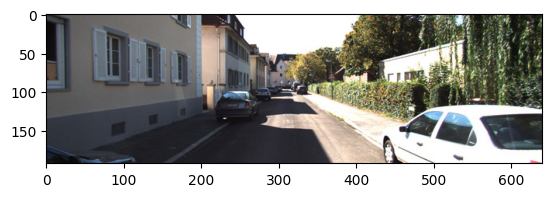

In [17]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

filtered_data = [entry for entry in train_filenames if entry.endswith(' l')]
train_filenames = sorted(filtered_data, key=extract_sort_keys)
fraction_trajectory_1 = train_filenames[7739:7739+40]
# fraction_trajectory_1 = train_filenames[0:50]
dataset_trajectory_1 = datasets.KITTIRAWDataset("kitti", fraction_trajectory_1,
                                           192, 640,
                                           [0, -1, 1], 4, use_imu=True, is_train=False)


dataloader_trajectory_1 = DataLoader(dataset_trajectory_1, 1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
list_frames_traj_1 = []
alpha, R_c, R_cbt_bc, delta_t, gravities, velocities = [], [], [], [], [], []
start_time = time.time()
avg_velocity = []
for idx,sample in enumerate(dataloader_trajectory_1):

    # Standard processing
    for key, ipt in sample.items():
            if key in [("preint_imu", -1, 0), ("preint_imu", 0, 1)]:
                for pkey, pipt in sample[key].items():
                    # inputs[key][pkey] = pipt.to(self.device).type(torch.float32)
                    sample[key][pkey] = pipt.to(device, dtype=torch.float32)
            else:
                # inputs[key] = ipt.to(self.device).type(torch.float32)
                sample[key] = ipt.to(device, dtype=torch.float32)
    
    if idx == 0:
        init_sample = sample
        init_image = sample[('color', 0, 0)]
    frames = sample[('color', 0, 0)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames
    im = ax.imshow(frame_data[0].permute(1, 2, 0).detach().numpy(), cmap='viridis')
    
    list_frames_traj_1.append(im)

    plt.close(fig)

    # Get IMU parameters
    next_imu = sample[('preint_imu',-1,0)]
    alpha.append(next_imu["alpha"])
    R_c.append(next_imu["R_c"])
    R_cbt_bc.append(next_imu["R_cbt_bc"])
    delta_t.append(next_imu["delta_t"])
    avg_velocity.append(next_imu["v_norm"])

image_frames_traj_1 = [im.get_array() for im in list_frames_traj_1]

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Initialize the image on the axis (using the first frame's shape)
im = ax.imshow(image_frames_traj_1[0], cmap='viridis')

# Update function for animation
def update(frame):
    im.set_data(frame)
    return [im]

# Create an animation
ani = animation.FuncAnimation(
    fig, update, frames=image_frames_traj_1, interval=100, blit=True
)

    # Save the animation as a video file (e.g., MP4)
ani.save('Trajectories_anim/trajectory_1.mp4', writer='ffmpeg', fps=10)

vel_1 = torch.mean(torch.stack(avg_velocity),dim=0)
print(f"average velocity: {vel_1}")

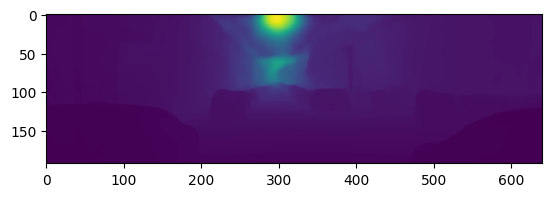

/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


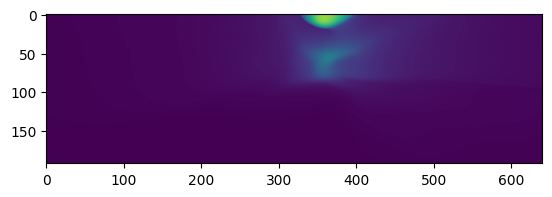

In [18]:
#depth
TRANS_SCALE_FACTOR = 5.4
pair_inputs = [init_sample[('color', 0, 0)],init_sample[('color', 1, 0)]]

# velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
velo_inputs = [models["velo_encoder"](torch.cat(pair_inputs, 1))]
# gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
gravity_inputs = [models["gravity_encoder"](torch.cat(pair_inputs, 1))]


velocity = models["velo"](velo_inputs)
gravity = models["gravity"](gravity_inputs)

R_cbt_bc[0] = R_cbt_bc[0]

# poses_trajectory_1 = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
# disp_trajectory_1 = models["depth"](models["encoder"](torch.unsqueeze(init_sample[('color', 0, 0)],dim=0)))
disp_trajectory_1 =  models["depth"](models["encoder"](init_image))
# poses_depth = get_poses_depth(poses_trajectory_1,dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
poses_depth = get_poses_depth(dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],poses_depth,init_sample,init_image)
# depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],diagonal_pose_with_z_translation,init_sample,init_image)


get_video_depth(depth_after_imu,"Depth_anim/depth_trajectory_1.mp4")

Make plot for report

(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


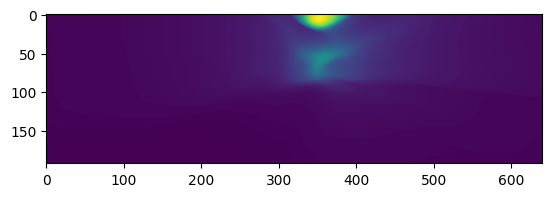

In [19]:
file_name = "500000.png"
idx2 = [0,5,10,15,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
for i in range(len(image_frames_traj_1)):
    if i in idx2:
        image = image_frames_traj_1[i]
        save_file = file_name.split(".")[0] + f"_{i}.png"
        plt.imshow(image)
        plt.imsave(f"/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Report_images_1/{save_file}",image)
        
file_name = "600000.png"
for i in range(len(depth_after_imu)):
    if i in idx2:
        image = depth_after_imu[i][0]
        save_file = file_name.split(".")[0] + f"_{i}.png"
        print(image.permute(1,2,0).detach().numpy().shape)
        plt.imshow(image.permute(1,2,0).detach().numpy())
        plt.imsave(f"/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Report_images_1/{save_file}",image.squeeze().detach().numpy(), cmap='viridis')
        

In [20]:
# importlib.reload(export_gt_depths_kitti_part2)

export_gt_depths_kitti_part2(fraction_trajectory_1,traj=1)


def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Read ground truth depth
gt_path = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_1_gt/gt_depths.npz"
gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

disable_median_scaling = True

errors_traj_1 = []
ratios = []
pred_depths = depth_after_imu
pred_depths = torch.stack(pred_depths,dim=0)
pred_depths = pred_depths.cpu().detach().numpy()
print(len(pred_depths))
print(len(gt_depths))
for i in range(pred_depths.shape[0]):

    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_depth = pred_depths[i]
    print(np.squeeze(pred_depth,axis=(0,1)).shape)
    pred_depth = cv2.resize(np.squeeze(pred_depth,axis=(0,1)), (gt_width, gt_height))

   
    mask = gt_depth > 0

    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]

    # if not opt.disable_median_scaling:
    if disable_median_scaling:
        ratio = np.median(gt_depth) / np.median(pred_depth)
        ratios.append(ratio)
        pred_depth *= ratio

    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

    errors_traj_1.append(compute_errors(gt_depth, pred_depth))

# if not opt.disable_median_scaling:
if disable_median_scaling:
    ratios = np.array(ratios)
    med = np.median(ratios)
    print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))
#     if opt.show_scale_hist:
#         pdb.set_trace()

mean_errors = np.array(errors_traj_1).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")



Saving to /Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_1_gt/gt_depths.npz
40
40
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
 Scaling ratios | med: 6.684 | std: 0.323

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.277  &   2.035  &   5.725  &   0.374  &   0.584  &   0.778  &   0.891  \\

-> Done!


Text(0, 0.5, 'RMSE')

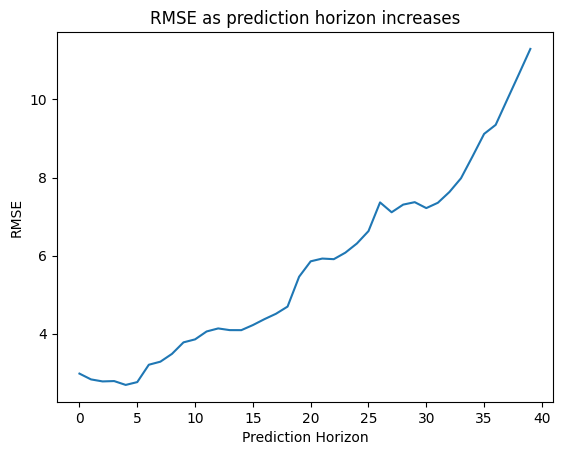

In [21]:
rmse_trajectory_1 = [item[2] for item in errors_traj_1]
plt.title("RMSE as prediction horizon increases")
plt.plot(rmse_trajectory_1)
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")

## Trajectory 2

Preintegrating IMU data (Save raw wa_xyz also)...


  0%|          | 0/1 [00:00<?, ?it/s]

=> Read IMU file: kitti/2011_09_30/2011_09_30_drive_0028_sync/matched_oxts/matched_oxts.txt


100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


=> Num of filenames before filtering based on IMU nan: 40
=> Num of filenames After filtering based on IMU nan: 40
average velocity: tensor([8.4912])


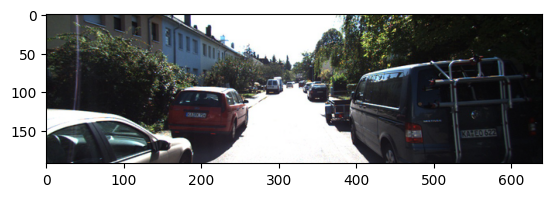

In [22]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

filtered_data = [entry for entry in train_filenames if entry.endswith(' l')]
train_filenames = sorted(filtered_data, key=extract_sort_keys)
# fraction_trajectory_2 = train_filenames[7629+1480:7629+1480+40]
# fraction_trajectory_2 = train_filenames[7629+1520:7629+1520+40]
# fraction_trajectory_2 = train_filenames[7629+1560:7629+1560+40]
fraction_trajectory_2 = train_filenames[9100:9100+40]
# fraction_trajectory_2 = train_filenames[9000:9000+120]

# fraction_trajectory_1 = train_filenames[0:50]
dataset_trajectory_2 = datasets.KITTIRAWDataset("kitti", fraction_trajectory_2,
                                           192, 640,
                                           [0, -1, 1], 4, use_imu=True, is_train=False)


dataloader_trajectory_2 = DataLoader(dataset_trajectory_2, 1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
list_frames_traj_2 = []
alpha, R_c, R_cbt_bc, delta_t, gravities, velocities = [], [], [], [], [], []
start_time = time.time()
avg_velocity = []
for idx,sample in enumerate(dataloader_trajectory_2):

    # Standard processing
    for key, ipt in sample.items():
            if key in [("preint_imu", -1, 0), ("preint_imu", 0, 1)]:
                for pkey, pipt in sample[key].items():
                    # inputs[key][pkey] = pipt.to(self.device).type(torch.float32)
                    sample[key][pkey] = pipt.to(device, dtype=torch.float32)
            else:
                # inputs[key] = ipt.to(self.device).type(torch.float32)
                sample[key] = ipt.to(device, dtype=torch.float32)
    
    if idx == 0:
        init_sample = sample
        init_image = sample[('color', 0, 0)]
    frames = sample[('color', 0, 0)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames
    im = ax.imshow(frame_data[0].permute(1, 2, 0).detach().numpy(), cmap='viridis')
    
    list_frames_traj_2.append(im)

    plt.close(fig)

    # Get IMU parameters
    next_imu = sample[('preint_imu',-1,0)]
    alpha.append(next_imu["alpha"])
    R_c.append(next_imu["R_c"])
    R_cbt_bc.append(next_imu["R_cbt_bc"])
    delta_t.append(next_imu["delta_t"])
    avg_velocity.append(next_imu["v_norm"])

image_frames_traj_2 = [im.get_array() for im in list_frames_traj_2]

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Initialize the image on the axis (using the first frame's shape)
im = ax.imshow(image_frames_traj_2[0], cmap='viridis')

# Update function for animation
def update(frame):
    im.set_data(frame)
    return [im]

# Create an animation
ani = animation.FuncAnimation(
    fig, update, frames=image_frames_traj_2, interval=100, blit=True
)

    # Save the animation as a video file (e.g., MP4)
ani.save('Trajectories_anim/trajectory_2.mp4', writer='ffmpeg', fps=10)
vel_2 = torch.mean(torch.stack(avg_velocity),dim=0)
print(f"average velocity: {vel_2}")

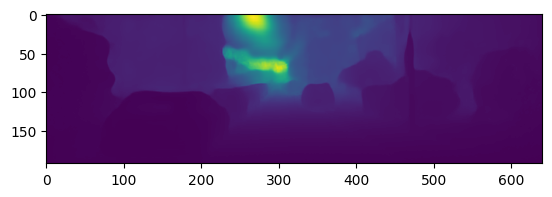

/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


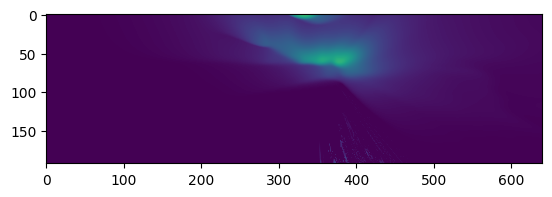

In [23]:
#depth
TRANS_SCALE_FACTOR = 5.4
pair_inputs = [init_sample[('color', 0, 0)],init_sample[('color', 1, 0)]]

# velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
velo_inputs = [models["velo_encoder"](torch.cat(pair_inputs, 1))]
# gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
gravity_inputs = [models["gravity_encoder"](torch.cat(pair_inputs, 1))]


velocity = models["velo"](velo_inputs)
gravity = models["gravity"](gravity_inputs)

R_cbt_bc[0] = R_cbt_bc[0]

# poses_trajectory_1 = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
# disp_trajectory_1 = models["depth"](models["encoder"](torch.unsqueeze(init_sample[('color', 0, 0)],dim=0)))
disp_trajectory_2 =  models["depth"](models["encoder"](init_image))
# poses_depth = get_poses_depth(poses_trajectory_1,dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
poses_depth = get_poses_depth(dataset_trajectory_2,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
depth_after_imu,depth_init_trajectory_2,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_2[("disp", 0)],poses_depth,init_sample,init_image)
# depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],diagonal_pose_with_z_translation,init_sample,init_image)


get_video_depth(depth_after_imu,"Depth_anim/depth_trajectory_2.mp4")

In [24]:
# importlib.reload(export_gt_depths_kitti_part2)

export_gt_depths_kitti_part2(fraction_trajectory_2,traj=2)


def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Read ground truth depth
gt_path = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_2_gt/gt_depths.npz"
gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

disable_median_scaling = True

errors_traj_2 = []
ratios = []
pred_depths = depth_after_imu
pred_depths = torch.stack(pred_depths,dim=0)
pred_depths = pred_depths.cpu().detach().numpy()
print(len(pred_depths))
print(len(gt_depths))
for i in range(pred_depths.shape[0]):

    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_depth = pred_depths[i]
    print(np.squeeze(pred_depth,axis=(0,1)).shape)
    pred_depth = cv2.resize(np.squeeze(pred_depth,axis=(0,1)), (gt_width, gt_height))

   
    mask = gt_depth > 0

    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]

    # if not opt.disable_median_scaling:
    if disable_median_scaling:
        ratio = np.median(gt_depth) / np.median(pred_depth)
        ratios.append(ratio)
        pred_depth *= ratio

    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

    errors_traj_2.append(compute_errors(gt_depth, pred_depth))

# if not opt.disable_median_scaling:
if disable_median_scaling:
    ratios = np.array(ratios)
    med = np.median(ratios)
    print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))
#     if opt.show_scale_hist:
#         pdb.set_trace()

mean_errors = np.array(errors_traj_1).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")



Saving to /Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_2_gt/gt_depths.npz
40
40
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
 Scaling ratios | med: 7.439 | std: 0.285

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.277  &   2.035  &   5.725  &   0.374  &   0.584  &   0.778  &   0.891  \\

-> Done!


Text(0, 0.5, 'RMSE')

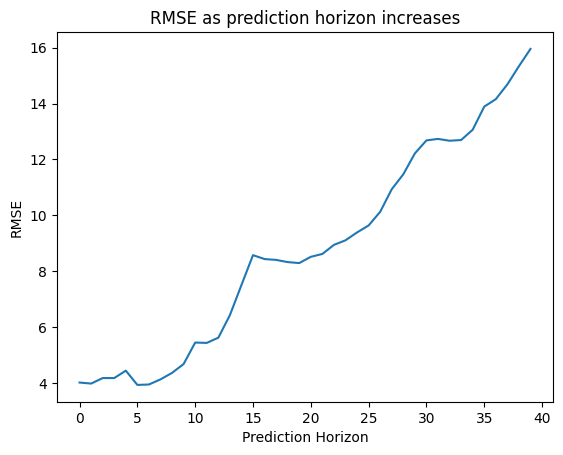

In [25]:
rmse_trajectory_2 = [item[2] for item in errors_traj_2]
plt.title("RMSE as prediction horizon increases")
plt.plot(rmse_trajectory_2)
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")

## Trajectory 3

Preintegrating IMU data (Save raw wa_xyz also)...


  0%|          | 0/1 [00:00<?, ?it/s]

=> Read IMU file: kitti/2011_09_30/2011_09_30_drive_0028_sync/matched_oxts/matched_oxts.txt


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


=> Num of filenames before filtering based on IMU nan: 40
=> Num of filenames After filtering based on IMU nan: 40
average velocity: tensor([9.4672])


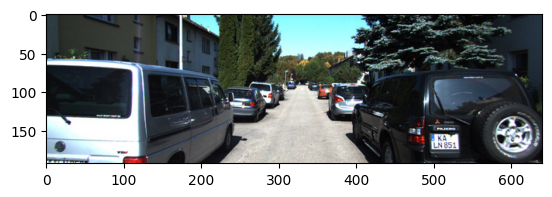

In [26]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

filtered_data = [entry for entry in train_filenames if entry.endswith(' l')]
train_filenames = sorted(filtered_data, key=extract_sort_keys)
fraction_trajectory_3 = train_filenames[7629+1725:7629+1725+40]
dataset_trajectory_3 = datasets.KITTIRAWDataset("kitti", fraction_trajectory_3,
                                           192, 640,
                                           [0, -1, 1], 4, use_imu=True, is_train=False)


dataloader_trajectory_3 = DataLoader(dataset_trajectory_3, 1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
list_frames_traj_3 = []
alpha, R_c, R_cbt_bc, delta_t, gravities, velocities = [], [], [], [], [], []
start_time = time.time()
avg_velocity = []

for idx,sample in enumerate(dataloader_trajectory_3):

    # Standard processing
    for key, ipt in sample.items():
            if key in [("preint_imu", -1, 0), ("preint_imu", 0, 1)]:
                for pkey, pipt in sample[key].items():
                    # inputs[key][pkey] = pipt.to(self.device).type(torch.float32)
                    sample[key][pkey] = pipt.to(device, dtype=torch.float32)
            else:
                # inputs[key] = ipt.to(self.device).type(torch.float32)
                sample[key] = ipt.to(device, dtype=torch.float32)
    
    if idx == 0:
        init_sample = sample
        init_image = sample[('color', 0, 0)]
    frames = sample[('color', 0, 0)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames
    im = ax.imshow(frame_data[0].permute(1, 2, 0).detach().numpy(), cmap='viridis')
    
    list_frames_traj_3.append(im)

    plt.close(fig)

    # Get IMU parameters
    next_imu = sample[('preint_imu',-1,0)]
    alpha.append(next_imu["alpha"])
    R_c.append(next_imu["R_c"])
    R_cbt_bc.append(next_imu["R_cbt_bc"])
    delta_t.append(next_imu["delta_t"])
    avg_velocity.append(next_imu["v_norm"])

image_frames_traj_3 = [im.get_array() for im in list_frames_traj_3]

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Initialize the image on the axis (using the first frame's shape)
im = ax.imshow(image_frames_traj_3[0], cmap='viridis')

# Update function for animation
def update(frame):
    im.set_data(frame)
    return [im]

# Create an animation
ani = animation.FuncAnimation(
    fig, update, frames=image_frames_traj_3, interval=100, blit=True
)

    # Save the animation as a video file (e.g., MP4)
ani.save('Trajectories_anim/trajectory_3.mp4', writer='ffmpeg', fps=10)
vel_3 = torch.mean(torch.stack(avg_velocity),dim=0)
print(f"average velocity: {vel_3}")

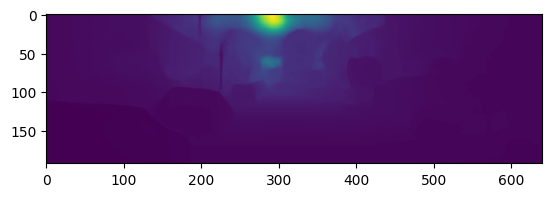

/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


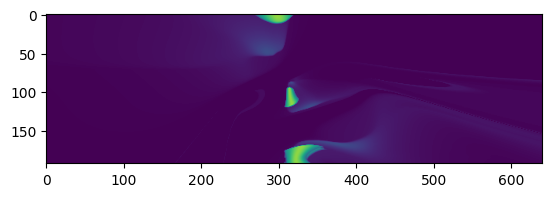

In [27]:
#depth
TRANS_SCALE_FACTOR = 5.4
pair_inputs = [init_sample[('color', 0, 0)],init_sample[('color', 1, 0)]]

# velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
velo_inputs = [models["velo_encoder"](torch.cat(pair_inputs, 1))]
# gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
gravity_inputs = [models["gravity_encoder"](torch.cat(pair_inputs, 1))]


velocity = models["velo"](velo_inputs)
gravity = models["gravity"](gravity_inputs)

R_cbt_bc[0] = R_cbt_bc[0]

# poses_trajectory_1 = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
# disp_trajectory_1 = models["depth"](models["encoder"](torch.unsqueeze(init_sample[('color', 0, 0)],dim=0)))
disp_trajectory_3 =  models["depth"](models["encoder"](init_image))
# poses_depth = get_poses_depth(poses_trajectory_1,dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
poses_depth = get_poses_depth(dataset_trajectory_3,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
depth_after_imu,depth_init_trajectory_3,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_3[("disp", 0)],poses_depth,init_sample,init_image)
# depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],diagonal_pose_with_z_translation,init_sample,init_image)


get_video_depth(depth_after_imu,"Depth_anim/depth_trajectory_3.mp4")

In [28]:
# importlib.reload(export_gt_depths_kitti_part2)

export_gt_depths_kitti_part2(fraction_trajectory_3,traj=3)


def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Read ground truth depth
gt_path = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_3_gt/gt_depths.npz"
gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

disable_median_scaling = True

errors_traj_3 = []
ratios = []
pred_depths = depth_after_imu
pred_depths = torch.stack(pred_depths,dim=0)
pred_depths = pred_depths.cpu().detach().numpy()
print(len(pred_depths))
print(len(gt_depths))
for i in range(pred_depths.shape[0]):

    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_depth = pred_depths[i]
    print(np.squeeze(pred_depth,axis=(0,1)).shape)
    pred_depth = cv2.resize(np.squeeze(pred_depth,axis=(0,1)), (gt_width, gt_height))

   
    mask = gt_depth > 0

    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]

    # if not opt.disable_median_scaling:
    if disable_median_scaling:
        ratio = np.median(gt_depth) / np.median(pred_depth)
        ratios.append(ratio)
        pred_depth *= ratio

    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

    errors_traj_3.append(compute_errors(gt_depth, pred_depth))

# if not opt.disable_median_scaling:
if disable_median_scaling:
    ratios = np.array(ratios)
    med = np.median(ratios)
    print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))
#     if opt.show_scale_hist:
#         pdb.set_trace()

mean_errors = np.array(errors_traj_3).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")



Saving to /Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_3_gt/gt_depths.npz
40
40
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
 Scaling ratios | med: 6.740 | std: 4.526

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.446  &  12.335  &   7.414  &   0.733  &   0.600  &   0.776  &   0.861  \\

-> Done!


Text(0, 0.5, 'RMSE')

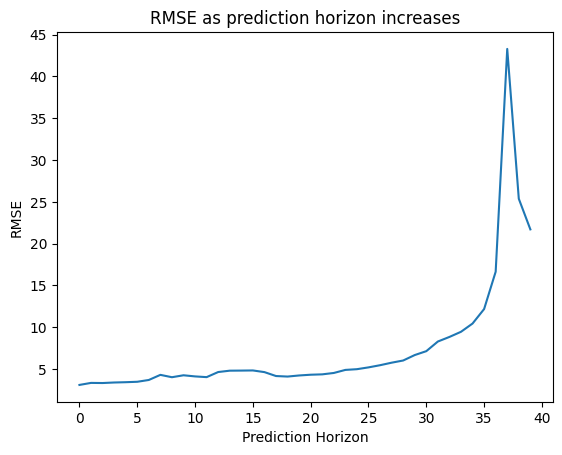

In [29]:
rmse_trajectory_3 = [item[2] for item in errors_traj_3]
plt.title("RMSE as prediction horizon increases")
plt.plot(rmse_trajectory_3)
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")

## Trajectory 4

Preintegrating IMU data (Save raw wa_xyz also)...


  0%|          | 0/1 [00:00<?, ?it/s]

=> Read IMU file: kitti/2011_09_30/2011_09_30_drive_0028_sync/matched_oxts/matched_oxts.txt


100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


=> Num of filenames before filtering based on IMU nan: 40
=> Num of filenames After filtering based on IMU nan: 40
average velocity: tensor([9.1204])


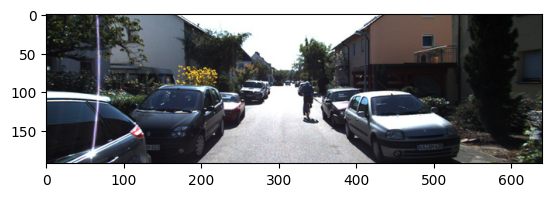

In [30]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

filtered_data = [entry for entry in train_filenames if entry.endswith(' l')]
train_filenames = sorted(filtered_data, key=extract_sort_keys)
fraction_trajectory_4 = train_filenames[7629+2045:7629+2045+40]
dataset_trajectory_4 = datasets.KITTIRAWDataset("kitti", fraction_trajectory_4,
                                           192, 640,
                                           [0, -1, 1], 4, use_imu=True, is_train=False)


dataloader_trajectory_4 = DataLoader(dataset_trajectory_4, 1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
list_frames_traj_4 = []
alpha, R_c, R_cbt_bc, delta_t, gravities, velocities = [], [], [], [], [], []
start_time = time.time()
avg_velocity = []
for idx,sample in enumerate(dataloader_trajectory_4):

    # Standard processing
    for key, ipt in sample.items():
            if key in [("preint_imu", -1, 0), ("preint_imu", 0, 1)]:
                for pkey, pipt in sample[key].items():
                    # inputs[key][pkey] = pipt.to(self.device).type(torch.float32)
                    sample[key][pkey] = pipt.to(device, dtype=torch.float32)
            else:
                # inputs[key] = ipt.to(self.device).type(torch.float32)
                sample[key] = ipt.to(device, dtype=torch.float32)
    
    if idx == 0:
        init_sample = sample
        init_image = sample[('color', 0, 0)]
    frames = sample[('color', 0, 0)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames
    im = ax.imshow(frame_data[0].permute(1, 2, 0).detach().numpy(), cmap='viridis')
    
    list_frames_traj_4.append(im)

    plt.close(fig)

    # Get IMU parameters
    next_imu = sample[('preint_imu',-1,0)]
    alpha.append(next_imu["alpha"])
    R_c.append(next_imu["R_c"])
    R_cbt_bc.append(next_imu["R_cbt_bc"])
    delta_t.append(next_imu["delta_t"])
    avg_velocity.append(next_imu["v_norm"])

image_frames_traj_4 = [im.get_array() for im in list_frames_traj_4]

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Initialize the image on the axis (using the first frame's shape)
im = ax.imshow(image_frames_traj_4[0], cmap='viridis')

# Update function for animation
def update(frame):
    im.set_data(frame)
    return [im]

# Create an animation
ani = animation.FuncAnimation(
    fig, update, frames=image_frames_traj_4, interval=100, blit=True
)

    # Save the animation as a video file (e.g., MP4)
ani.save('Trajectories_anim/trajectory_4.mp4', writer='ffmpeg', fps=10)

vel_4 = torch.mean(torch.stack(avg_velocity),dim=0)
print(f"average velocity: {vel_4}")

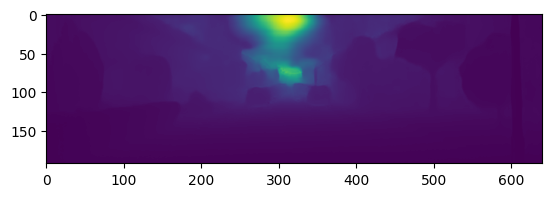

/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


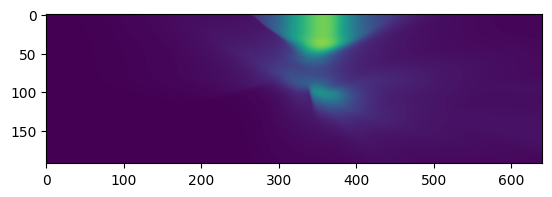

In [31]:
#depth
TRANS_SCALE_FACTOR = 5.4
pair_inputs = [init_sample[('color', 0, 0)],init_sample[('color', 1, 0)]]

# velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
velo_inputs = [models["velo_encoder"](torch.cat(pair_inputs, 1))]
# gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
gravity_inputs = [models["gravity_encoder"](torch.cat(pair_inputs, 1))]


velocity = models["velo"](velo_inputs)
gravity = models["gravity"](gravity_inputs)

R_cbt_bc[0] = R_cbt_bc[0]

# poses_trajectory_1 = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
# disp_trajectory_1 = models["depth"](models["encoder"](torch.unsqueeze(init_sample[('color', 0, 0)],dim=0)))
disp_trajectory_4 =  models["depth"](models["encoder"](init_image))
# poses_depth = get_poses_depth(poses_trajectory_1,dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
poses_depth = get_poses_depth(dataset_trajectory_4,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
depth_after_imu,depth_init_trajectory_4,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_4[("disp", 0)],poses_depth,init_sample,init_image)
# depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],diagonal_pose_with_z_translation,init_sample,init_image)


get_video_depth(depth_after_imu,"Depth_anim/depth_trajectory_4.mp4")

Get some plots for report

(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


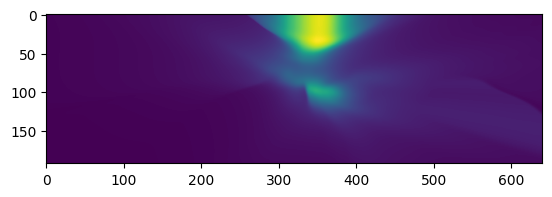

In [32]:
file_name = "500000.png"
idx2 = [0,5,10,15,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
for i in range(len(image_frames_traj_4)):
    if i in idx2:
        image = image_frames_traj_4[i]
        save_file = file_name.split(".")[0] + f"_{i}.png"
        plt.imshow(image)
        plt.imsave(f"/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Report_images_1/{save_file}",image)
        
file_name = "600000.png"
for i in range(len(depth_after_imu)):
    if i in idx2:
        image = depth_after_imu[i][0]
        save_file = file_name.split(".")[0] + f"_{i}.png"
        print(image.permute(1,2,0).detach().numpy().shape)
        plt.imshow(image.permute(1,2,0).detach().numpy())
        plt.imsave(f"/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Report_images_1/{save_file}",image.squeeze().detach().numpy(), cmap='viridis')
        

In [33]:
# importlib.reload(export_gt_depths_kitti_part2)

export_gt_depths_kitti_part2(fraction_trajectory_4,traj=4)


def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Read ground truth depth
gt_path = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_4_gt/gt_depths.npz"
gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

disable_median_scaling = True

errors_traj_4 = []
ratios = []
pred_depths = depth_after_imu
pred_depths = torch.stack(pred_depths,dim=0)
pred_depths = pred_depths.cpu().detach().numpy()
print(len(pred_depths))
print(len(gt_depths))
for i in range(pred_depths.shape[0]):

    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_depth = pred_depths[i]
    print(np.squeeze(pred_depth,axis=(0,1)).shape)
    pred_depth = cv2.resize(np.squeeze(pred_depth,axis=(0,1)), (gt_width, gt_height))

   
    mask = gt_depth > 0

    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]

    # if not opt.disable_median_scaling:
    if disable_median_scaling:
        ratio = np.median(gt_depth) / np.median(pred_depth)
        ratios.append(ratio)
        pred_depth *= ratio

    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

    errors_traj_4.append(compute_errors(gt_depth, pred_depth))

# if not opt.disable_median_scaling:
if disable_median_scaling:
    ratios = np.array(ratios)
    med = np.median(ratios)
    print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))
#     if opt.show_scale_hist:
#         pdb.set_trace()

mean_errors = np.array(errors_traj_4).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")



Saving to /Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_4_gt/gt_depths.npz
40
40
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
 Scaling ratios | med: 4.938 | std: 0.069

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.338  &   3.902  &   7.646  &   0.395  &   0.498  &   0.735  &   0.874  \\

-> Done!


Text(0, 0.5, 'RMSE')

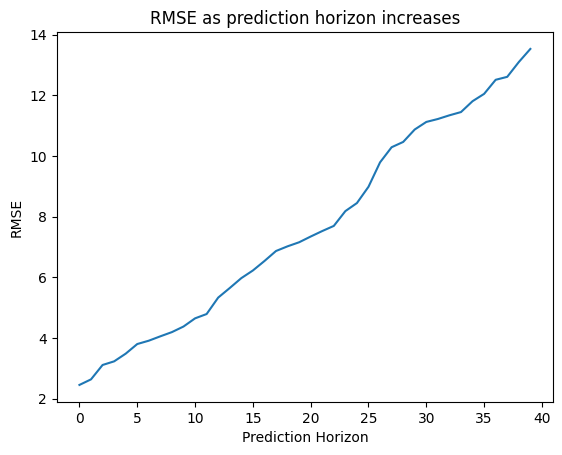

In [34]:
rmse_trajectory_4 = [item[2] for item in errors_traj_4]
plt.title("RMSE as prediction horizon increases")
plt.plot(rmse_trajectory_4)
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")

## Trajectory 5

Preintegrating IMU data (Save raw wa_xyz also)...


  0%|          | 0/1 [00:00<?, ?it/s]

=> Read IMU file: kitti/2011_09_30/2011_09_30_drive_0028_sync/matched_oxts/matched_oxts.txt


100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


=> Num of filenames before filtering based on IMU nan: 40
=> Num of filenames After filtering based on IMU nan: 40
average velocity: tensor([9.0910])


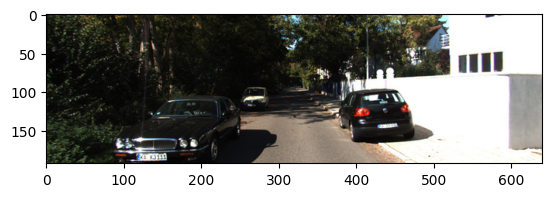

In [93]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

filtered_data = [entry for entry in train_filenames if entry.endswith(' l')]
train_filenames = sorted(filtered_data, key=extract_sort_keys)
# fraction_trajectory_5 = train_filenames[7629+2485:7629+2485+40]
# fraction_trajectory_5 = train_filenames[7629+2545:7629+2545+40]
# fraction_trajectory_5 = train_filenames[7629+7050:7629+7050+40]
# fraction_trajectory_5 = train_filenames[7629+1220:7629+1220+40]
# fraction_trajectory_5 = train_filenames[7629+1210:7629+1210+40]
fraction_trajectory_5 = train_filenames[11523:11523+40]
dataset_trajectory_5 = datasets.KITTIRAWDataset("kitti", fraction_trajectory_5,
                                           192, 640,
                                           [0, -1, 1], 4, use_imu=True, is_train=False)


dataloader_trajectory_5 = DataLoader(dataset_trajectory_5, 1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
list_frames_traj_5 = []
alpha, R_c, R_cbt_bc, delta_t, gravities, velocities = [], [], [], [], [], []
start_time = time.time()
avg_velocity = []
for idx,sample in enumerate(dataloader_trajectory_5):

    # Standard processing
    for key, ipt in sample.items():
            if key in [("preint_imu", -1, 0), ("preint_imu", 0, 1)]:
                for pkey, pipt in sample[key].items():
                    # inputs[key][pkey] = pipt.to(self.device).type(torch.float32)
                    sample[key][pkey] = pipt.to(device, dtype=torch.float32)
            else:
                # inputs[key] = ipt.to(self.device).type(torch.float32)
                sample[key] = ipt.to(device, dtype=torch.float32)
    
    if idx == 0:
        init_sample = sample
        init_image = sample[('color', 0, 0)]
    frames = sample[('color', 0, 0)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames
    im = ax.imshow(frame_data[0].permute(1, 2, 0).detach().numpy(), cmap='viridis')
    
    list_frames_traj_5.append(im)

    plt.close(fig)

    # Get IMU parameters
    next_imu = sample[('preint_imu',-1,0)]
    alpha.append(next_imu["alpha"])
    R_c.append(next_imu["R_c"])
    R_cbt_bc.append(next_imu["R_cbt_bc"])
    delta_t.append(next_imu["delta_t"])
    avg_velocity.append(next_imu["v_norm"])

image_frames_traj_5 = [im.get_array() for im in list_frames_traj_5]

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Initialize the image on the axis (using the first frame's shape)
im = ax.imshow(image_frames_traj_5[0], cmap='viridis')

# Update function for animation
def update(frame):
    im.set_data(frame)
    return [im]

# Create an animation
ani = animation.FuncAnimation(
    fig, update, frames=image_frames_traj_5, interval=100, blit=True
)

    # Save the animation as a video file (e.g., MP4)
ani.save('Trajectories_anim/trajectory_5.mp4', writer='ffmpeg', fps=10)

vel_5 = torch.mean(torch.stack(avg_velocity),dim=0)
print(f"average velocity: {vel_5}")

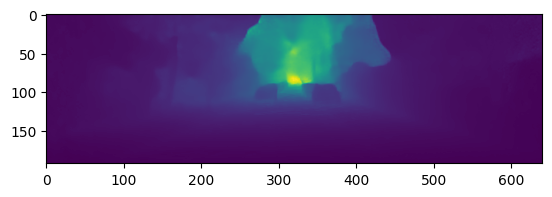

/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


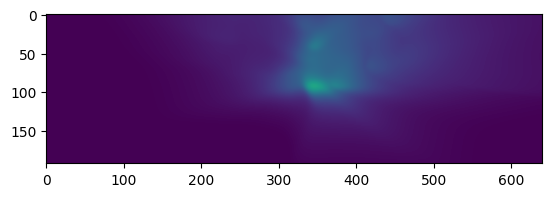

In [94]:
#depth
TRANS_SCALE_FACTOR = 5.4
pair_inputs = [init_sample[('color', 0, 0)],init_sample[('color', 1, 0)]]

# velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
velo_inputs = [models["velo_encoder"](torch.cat(pair_inputs, 1))]
# gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
gravity_inputs = [models["gravity_encoder"](torch.cat(pair_inputs, 1))]


velocity = models["velo"](velo_inputs)
gravity = models["gravity"](gravity_inputs)

R_cbt_bc[0] = R_cbt_bc[0]

# poses_trajectory_1 = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
# disp_trajectory_1 = models["depth"](models["encoder"](torch.unsqueeze(init_sample[('color', 0, 0)],dim=0)))
disp_trajectory_5 =  models["depth"](models["encoder"](init_image))
# poses_depth = get_poses_depth(poses_trajectory_1,dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
poses_depth = get_poses_depth(dataset_trajectory_5,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
depth_after_imu,depth_init_trajectory_5,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_5[("disp", 0)],poses_depth,init_sample,init_image)
# depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],diagonal_pose_with_z_translation,init_sample,init_image)


get_video_depth(depth_after_imu,"Depth_anim/depth_trajectory_5.mp4")

In [95]:
# importlib.reload(export_gt_depths_kitti_part2)

export_gt_depths_kitti_part2(fraction_trajectory_5,traj=5)


def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Read ground truth depth
gt_path = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_5_gt/gt_depths.npz"
gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

disable_median_scaling = True

errors_traj_5 = []
ratios = []
pred_depths = depth_after_imu
pred_depths = torch.stack(pred_depths,dim=0)
pred_depths = pred_depths.cpu().detach().numpy()
print(len(pred_depths))
print(len(gt_depths))
for i in range(pred_depths.shape[0]):

    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_depth = pred_depths[i]
    print(np.squeeze(pred_depth,axis=(0,1)).shape)
    pred_depth = cv2.resize(np.squeeze(pred_depth,axis=(0,1)), (gt_width, gt_height))

    mask = gt_depth > 0

    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]

    # if not opt.disable_median_scaling:
    if disable_median_scaling:
        ratio = np.median(gt_depth) / np.median(pred_depth)
        ratios.append(ratio)
        pred_depth *= ratio

    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

    errors_traj_5.append(compute_errors(gt_depth, pred_depth))

# if not opt.disable_median_scaling:
if disable_median_scaling:
    ratios = np.array(ratios)
    med = np.median(ratios)
    print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))
#     if opt.show_scale_hist:
#         pdb.set_trace()

mean_errors = np.array(errors_traj_5).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")

Saving to /Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_5_gt/gt_depths.npz
40
40
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
 Scaling ratios | med: 5.746 | std: 0.170

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.273  &   2.078  &   5.733  &   0.320  &   0.551  &   0.799  &   0.940  \\

-> Done!


Text(0, 0.5, 'RMSE')

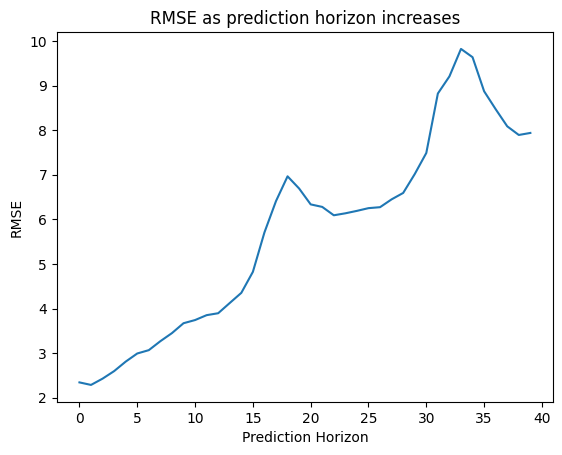

In [96]:
rmse_trajectory_5 = [item[2] for item in errors_traj_5]
plt.title("RMSE as prediction horizon increases")
plt.plot(rmse_trajectory_5)
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")

## Trajectory 6

Preintegrating IMU data (Save raw wa_xyz also)...


  0%|          | 0/1 [00:00<?, ?it/s]

=> Read IMU file: kitti/2011_09_30/2011_09_30_drive_0028_sync/matched_oxts/matched_oxts.txt


100%|██████████| 1/1 [00:03<00:00,  3.95s/it]


=> Num of filenames before filtering based on IMU nan: 40
=> Num of filenames After filtering based on IMU nan: 40
average velocity: tensor([10.7550])


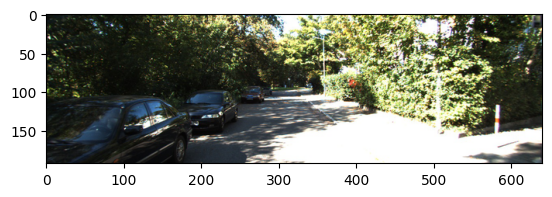

In [109]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

filtered_data = [entry for entry in train_filenames if entry.endswith(' l')]
train_filenames = sorted(filtered_data, key=extract_sort_keys)
# fraction_trajectory_5 = train_filenames[7629+2485:7629+2485+40]
# fraction_trajectory_5 = train_filenames[7629+2545:7629+2545+40]
# fraction_trajectory_5 = train_filenames[7629+7050:7629+7050+40]
# fraction_trajectory_5 = train_filenames[7629+1220:7629+1220+40]
# fraction_trajectory_6 = train_filenames[1415:1415+40]
fraction_trajectory_6 = train_filenames[11572:11572+40]
dataset_trajectory_6 = datasets.KITTIRAWDataset("kitti", fraction_trajectory_6,
                                           192, 640,
                                           [0, -1, 1], 4, use_imu=True, is_train=False)


dataloader_trajectory_6 = DataLoader(dataset_trajectory_6, 1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
list_frames_traj_6 = []
alpha, R_c, R_cbt_bc, delta_t, gravities, velocities = [], [], [], [], [], []
start_time = time.time()
avg_velocity = []
for idx,sample in enumerate(dataloader_trajectory_6):

    # Standard processing
    for key, ipt in sample.items():
            if key in [("preint_imu", -1, 0), ("preint_imu", 0, 1)]:
                for pkey, pipt in sample[key].items():
                    # inputs[key][pkey] = pipt.to(self.device).type(torch.float32)
                    sample[key][pkey] = pipt.to(device, dtype=torch.float32)
            else:
                # inputs[key] = ipt.to(self.device).type(torch.float32)
                sample[key] = ipt.to(device, dtype=torch.float32)
    
    if idx == 0:
        init_sample = sample
        init_image = sample[('color', 0, 0)]
    frames = sample[('color', 0, 0)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames
    im = ax.imshow(frame_data[0].permute(1, 2, 0).detach().numpy(), cmap='viridis')
    
    list_frames_traj_6.append(im)

    plt.close(fig)

    # Get IMU parameters
    next_imu = sample[('preint_imu',-1,0)]
    alpha.append(next_imu["alpha"])
    R_c.append(next_imu["R_c"])
    R_cbt_bc.append(next_imu["R_cbt_bc"])
    delta_t.append(next_imu["delta_t"])
    avg_velocity.append(next_imu["v_norm"])

image_frames_traj_6 = [im.get_array() for im in list_frames_traj_6]

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Initialize the image on the axis (using the first frame's shape)
im = ax.imshow(image_frames_traj_6[0], cmap='viridis')

# Update function for animation
def update(frame):
    im.set_data(frame)
    return [im]

# Create an animation
ani = animation.FuncAnimation(
    fig, update, frames=image_frames_traj_6, interval=100, blit=True
)

    # Save the animation as a video file (e.g., MP4)
ani.save('Trajectories_anim/trajectory_6.mp4', writer='ffmpeg', fps=10)

vel_6 = torch.mean(torch.stack(avg_velocity),dim=0)
print(f"average velocity: {vel_6}")

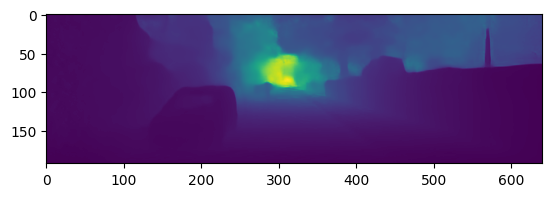

/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


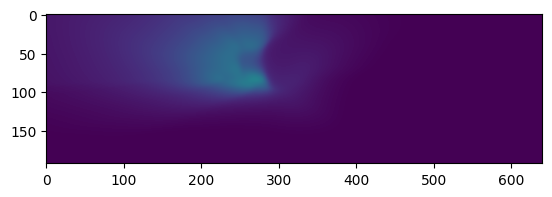

In [110]:
#depth
TRANS_SCALE_FACTOR = 5.4
pair_inputs = [init_sample[('color', 0, 0)],init_sample[('color', 1, 0)]]

# velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
velo_inputs = [models["velo_encoder"](torch.cat(pair_inputs, 1))]
# gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
gravity_inputs = [models["gravity_encoder"](torch.cat(pair_inputs, 1))]


velocity = models["velo"](velo_inputs)
gravity = models["gravity"](gravity_inputs)

R_cbt_bc[0] = R_cbt_bc[0]

# poses_trajectory_1 = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
# disp_trajectory_1 = models["depth"](models["encoder"](torch.unsqueeze(init_sample[('color', 0, 0)],dim=0)))
disp_trajectory_6 =  models["depth"](models["encoder"](init_image))
# poses_depth = get_poses_depth(poses_trajectory_1,dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
poses_depth = get_poses_depth(dataset_trajectory_6,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
depth_after_imu,depth_init_trajectory_6,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_6[("disp", 0)],poses_depth,init_sample,init_image)
# depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],diagonal_pose_with_z_translation,init_sample,init_image)


get_video_depth(depth_after_imu,"Depth_anim/depth_trajectory_6.mp4")

In [111]:
# importlib.reload(export_gt_depths_kitti_part2)

export_gt_depths_kitti_part2(fraction_trajectory_6,traj=6)


def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Read ground truth depth
gt_path = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_6_gt/gt_depths.npz"
gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

disable_median_scaling = True

errors_traj_6 = []
ratios = []
pred_depths = depth_after_imu
pred_depths = torch.stack(pred_depths,dim=0)
pred_depths = pred_depths.cpu().detach().numpy()
print(len(pred_depths))
print(len(gt_depths))
for i in range(pred_depths.shape[0]):

    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_depth = pred_depths[i]
    print(np.squeeze(pred_depth,axis=(0,1)).shape)
    pred_depth = cv2.resize(np.squeeze(pred_depth,axis=(0,1)), (gt_width, gt_height))

    mask = gt_depth > 0

    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]

    # if not opt.disable_median_scaling:
    if disable_median_scaling:
        ratio = np.median(gt_depth) / np.median(pred_depth)
        ratios.append(ratio)
        pred_depth *= ratio

    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

    errors_traj_6.append(compute_errors(gt_depth, pred_depth))

# if not opt.disable_median_scaling:
if disable_median_scaling:
    ratios = np.array(ratios)
    med = np.median(ratios)
    print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))
#     if opt.show_scale_hist:
#         pdb.set_trace()

mean_errors = np.array(errors_traj_6).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")

Saving to /Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_6_gt/gt_depths.npz
40
40
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
 Scaling ratios | med: 7.200 | std: 0.325

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.280  &   3.272  &   7.339  &   0.360  &   0.649  &   0.808  &   0.894  \\

-> Done!


Text(0, 0.5, 'RMSE')

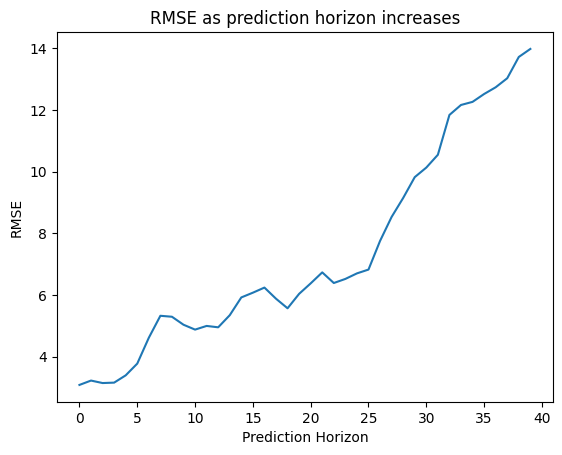

In [112]:
rmse_trajectory_6 = [item[2] for item in errors_traj_6]
plt.title("RMSE as prediction horizon increases")
plt.plot(rmse_trajectory_6)
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")

## Trajectory 7

Preintegrating IMU data (Save raw wa_xyz also)...


  0%|          | 0/1 [00:00<?, ?it/s]

=> Read IMU file: kitti/2011_09_26/2011_09_26_drive_0022_sync/matched_oxts/matched_oxts.txt


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


=> Num of filenames before filtering based on IMU nan: 40
=> Num of filenames After filtering based on IMU nan: 40
average velocity: tensor([8.9375])


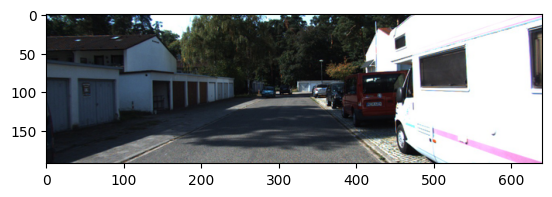

In [48]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

filtered_data = [entry for entry in train_filenames if entry.endswith(' l')]
train_filenames = sorted(filtered_data, key=extract_sort_keys)
# fraction_trajectory_5 = train_filenames[7629+2485:7629+2485+40]
# fraction_trajectory_5 = train_filenames[7629+2545:7629+2545+40]
# fraction_trajectory_5 = train_filenames[7629+7050:7629+7050+40]
# fraction_trajectory_5 = train_filenames[7629+1220:7629+1220+40]
fraction_trajectory_7 = train_filenames[1481:1481+40]
dataset_trajectory_7 = datasets.KITTIRAWDataset("kitti", fraction_trajectory_7,
                                           192, 640,
                                           [0, -1, 1], 4, use_imu=True, is_train=False)


dataloader_trajectory_7 = DataLoader(dataset_trajectory_7, 1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
list_frames_traj_7 = []
alpha, R_c, R_cbt_bc, delta_t, gravities, velocities = [], [], [], [], [], []
start_time = time.time()
avg_velocity = []
for idx,sample in enumerate(dataloader_trajectory_7):

    # Standard processing
    for key, ipt in sample.items():
            if key in [("preint_imu", -1, 0), ("preint_imu", 0, 1)]:
                for pkey, pipt in sample[key].items():
                    # inputs[key][pkey] = pipt.to(self.device).type(torch.float32)
                    sample[key][pkey] = pipt.to(device, dtype=torch.float32)
            else:
                # inputs[key] = ipt.to(self.device).type(torch.float32)
                sample[key] = ipt.to(device, dtype=torch.float32)
    
    if idx == 0:
        init_sample = sample
        init_image = sample[('color', 0, 0)]
    frames = sample[('color', 0, 0)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames
    im = ax.imshow(frame_data[0].permute(1, 2, 0).detach().numpy(), cmap='viridis')
    
    list_frames_traj_7.append(im)

    plt.close(fig)

    # Get IMU parameters
    next_imu = sample[('preint_imu',-1,0)]
    alpha.append(next_imu["alpha"])
    R_c.append(next_imu["R_c"])
    R_cbt_bc.append(next_imu["R_cbt_bc"])
    delta_t.append(next_imu["delta_t"])
    avg_velocity.append(next_imu["v_norm"])

image_frames_traj_7 = [im.get_array() for im in list_frames_traj_7]

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Initialize the image on the axis (using the first frame's shape)
im = ax.imshow(image_frames_traj_7[0], cmap='viridis')

# Update function for animation
def update(frame):
    im.set_data(frame)
    return [im]

# Create an animation
ani = animation.FuncAnimation(
    fig, update, frames=image_frames_traj_7, interval=100, blit=True
)

    # Save the animation as a video file (e.g., MP4)
ani.save('Trajectories_anim/trajectory_7.mp4', writer='ffmpeg', fps=10)

vel_7 = torch.mean(torch.stack(avg_velocity),dim=0)
print(f"average velocity: {vel_7}")

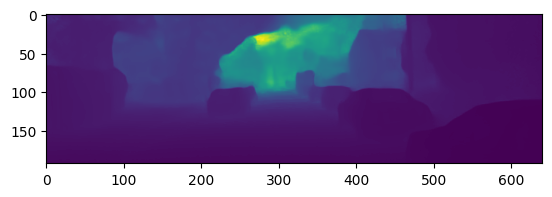

/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


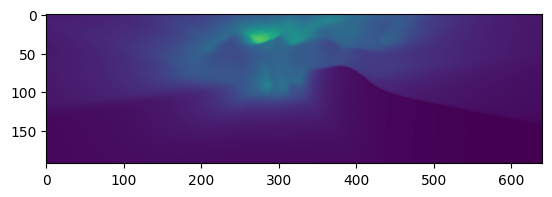

In [49]:
#depth
TRANS_SCALE_FACTOR = 5.4
pair_inputs = [init_sample[('color', 0, 0)],init_sample[('color', 1, 0)]]

# velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
velo_inputs = [models["velo_encoder"](torch.cat(pair_inputs, 1))]
# gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
gravity_inputs = [models["gravity_encoder"](torch.cat(pair_inputs, 1))]


velocity = models["velo"](velo_inputs)
gravity = models["gravity"](gravity_inputs)

R_cbt_bc[0] = R_cbt_bc[0]

# poses_trajectory_1 = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
# disp_trajectory_1 = models["depth"](models["encoder"](torch.unsqueeze(init_sample[('color', 0, 0)],dim=0)))
disp_trajectory_7 =  models["depth"](models["encoder"](init_image))
# poses_depth = get_poses_depth(poses_trajectory_1,dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
poses_depth = get_poses_depth(dataset_trajectory_7,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
depth_after_imu,depth_init_trajectory_7,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_7[("disp", 0)],poses_depth,init_sample,init_image)
# depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],diagonal_pose_with_z_translation,init_sample,init_image)


get_video_depth(depth_after_imu,"Depth_anim/depth_trajectory_7.mp4")

In [50]:
# importlib.reload(export_gt_depths_kitti_part2)

export_gt_depths_kitti_part2(fraction_trajectory_7,traj=7)


def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Read ground truth depth
gt_path = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_7_gt/gt_depths.npz"
gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

disable_median_scaling = True

errors_traj_7 = []
ratios = []
pred_depths = depth_after_imu
pred_depths = torch.stack(pred_depths,dim=0)
pred_depths = pred_depths.cpu().detach().numpy()
print(len(pred_depths))
print(len(gt_depths))
for i in range(pred_depths.shape[0]):

    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_depth = pred_depths[i]
    print(np.squeeze(pred_depth,axis=(0,1)).shape)
    pred_depth = cv2.resize(np.squeeze(pred_depth,axis=(0,1)), (gt_width, gt_height))

    mask = gt_depth > 0

    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]

    # if not opt.disable_median_scaling:
    if disable_median_scaling:
        ratio = np.median(gt_depth) / np.median(pred_depth)
        ratios.append(ratio)
        pred_depth *= ratio

    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

    errors_traj_7.append(compute_errors(gt_depth, pred_depth))

# if not opt.disable_median_scaling:
if disable_median_scaling:
    ratios = np.array(ratios)
    med = np.median(ratios)
    print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))
#     if opt.show_scale_hist:
#         pdb.set_trace()

mean_errors = np.array(errors_traj_7).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")

Saving to /Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_7_gt/gt_depths.npz
40
40
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
 Scaling ratios | med: 5.265 | std: 0.107

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.262  &   2.140  &   5.954  &   0.365  &   0.639  &   0.815  &   0.906  \\

-> Done!


Text(0, 0.5, 'RMSE')

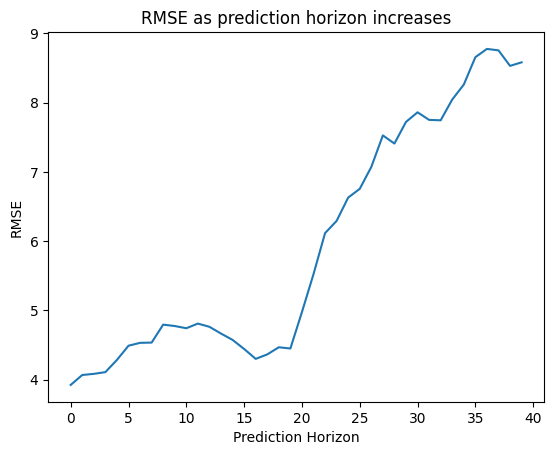

In [51]:
rmse_trajectory_7 = [item[2] for item in errors_traj_7]
plt.title("RMSE as prediction horizon increases")
plt.plot(rmse_trajectory_7)
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")

## Trajectory 8

Preintegrating IMU data (Save raw wa_xyz also)...


  0%|          | 0/1 [00:00<?, ?it/s]

=> Read IMU file: kitti/2011_09_26/2011_09_26_drive_0022_sync/matched_oxts/matched_oxts.txt


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


=> Num of filenames before filtering based on IMU nan: 40
=> Num of filenames After filtering based on IMU nan: 40
average velocity: tensor([8.5211])


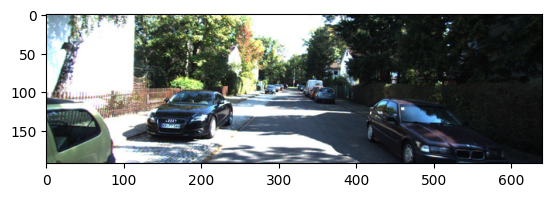

In [52]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

filtered_data = [entry for entry in train_filenames if entry.endswith(' l')]
train_filenames = sorted(filtered_data, key=extract_sort_keys)
# fraction_trajectory_5 = train_filenames[7629+2485:7629+2485+40]
# fraction_trajectory_5 = train_filenames[7629+2545:7629+2545+40]
# fraction_trajectory_5 = train_filenames[7629+7050:7629+7050+40]
# fraction_trajectory_5 = train_filenames[7629+1220:7629+1220+40]
fraction_trajectory_8 = train_filenames[1706:1706+40]
dataset_trajectory_8 = datasets.KITTIRAWDataset("kitti", fraction_trajectory_8,
                                           192, 640,
                                           [0, -1, 1], 4, use_imu=True, is_train=False)


dataloader_trajectory_8 = DataLoader(dataset_trajectory_8, 1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
list_frames_traj_8 = []
alpha, R_c, R_cbt_bc, delta_t, gravities, velocities = [], [], [], [], [], []
start_time = time.time()
avg_velocity = []
for idx,sample in enumerate(dataloader_trajectory_8):

    # Standard processing
    for key, ipt in sample.items():
            if key in [("preint_imu", -1, 0), ("preint_imu", 0, 1)]:
                for pkey, pipt in sample[key].items():
                    # inputs[key][pkey] = pipt.to(self.device).type(torch.float32)
                    sample[key][pkey] = pipt.to(device, dtype=torch.float32)
            else:
                # inputs[key] = ipt.to(self.device).type(torch.float32)
                sample[key] = ipt.to(device, dtype=torch.float32)
    
    if idx == 0:
        init_sample = sample
        init_image = sample[('color', 0, 0)]
    frames = sample[('color', 0, 0)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames
    im = ax.imshow(frame_data[0].permute(1, 2, 0).detach().numpy(), cmap='viridis')
    
    list_frames_traj_8.append(im)

    plt.close(fig)

    # Get IMU parameters
    next_imu = sample[('preint_imu',-1,0)]
    alpha.append(next_imu["alpha"])
    R_c.append(next_imu["R_c"])
    R_cbt_bc.append(next_imu["R_cbt_bc"])
    delta_t.append(next_imu["delta_t"])
    avg_velocity.append(next_imu["v_norm"])

image_frames_traj_8 = [im.get_array() for im in list_frames_traj_8]

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Initialize the image on the axis (using the first frame's shape)
im = ax.imshow(image_frames_traj_8[0], cmap='viridis')

# Update function for animation
def update(frame):
    im.set_data(frame)
    return [im]

# Create an animation
ani = animation.FuncAnimation(
    fig, update, frames=image_frames_traj_8, interval=100, blit=True
)

    # Save the animation as a video file (e.g., MP4)
ani.save('Trajectories_anim/trajectory_8.mp4', writer='ffmpeg', fps=10)

vel_8 = torch.mean(torch.stack(avg_velocity),dim=0)
print(f"average velocity: {vel_8}")

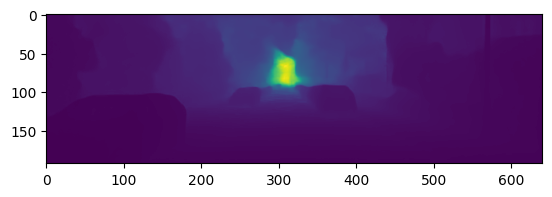

/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


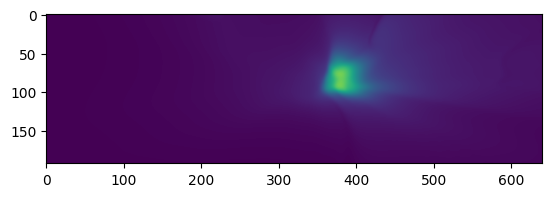

In [53]:
#depth
TRANS_SCALE_FACTOR = 5.4
pair_inputs = [init_sample[('color', 0, 0)],init_sample[('color', 1, 0)]]

# velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
velo_inputs = [models["velo_encoder"](torch.cat(pair_inputs, 1))]
# gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
gravity_inputs = [models["gravity_encoder"](torch.cat(pair_inputs, 1))]


velocity = models["velo"](velo_inputs)
gravity = models["gravity"](gravity_inputs)

R_cbt_bc[0] = R_cbt_bc[0]

# poses_trajectory_1 = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
# disp_trajectory_1 = models["depth"](models["encoder"](torch.unsqueeze(init_sample[('color', 0, 0)],dim=0)))
disp_trajectory_8 =  models["depth"](models["encoder"](init_image))
# poses_depth = get_poses_depth(poses_trajectory_1,dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
poses_depth = get_poses_depth(dataset_trajectory_8,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
depth_after_imu,depth_init_trajectory_8,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_8[("disp", 0)],poses_depth,init_sample,init_image)
# depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],diagonal_pose_with_z_translation,init_sample,init_image)


get_video_depth(depth_after_imu,"Depth_anim/depth_trajectory_8.mp4")

In [54]:
# importlib.reload(export_gt_depths_kitti_part2)

export_gt_depths_kitti_part2(fraction_trajectory_8,traj=8)


def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Read ground truth depth
gt_path = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_8_gt/gt_depths.npz"
gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

disable_median_scaling = True

errors_traj_8 = []
ratios = []
pred_depths = depth_after_imu
pred_depths = torch.stack(pred_depths,dim=0)
pred_depths = pred_depths.cpu().detach().numpy()
print(len(pred_depths))
print(len(gt_depths))
for i in range(pred_depths.shape[0]):

    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_depth = pred_depths[i]
    print(np.squeeze(pred_depth,axis=(0,1)).shape)
    pred_depth = cv2.resize(np.squeeze(pred_depth,axis=(0,1)), (gt_width, gt_height))

    mask = gt_depth > 0

    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]

    # if not opt.disable_median_scaling:
    if disable_median_scaling:
        ratio = np.median(gt_depth) / np.median(pred_depth)
        ratios.append(ratio)
        pred_depth *= ratio

    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

    errors_traj_8.append(compute_errors(gt_depth, pred_depth))

# if not opt.disable_median_scaling:
if disable_median_scaling:
    ratios = np.array(ratios)
    med = np.median(ratios)
    print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))
#     if opt.show_scale_hist:
#         pdb.set_trace()

mean_errors = np.array(errors_traj_8).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")

Saving to /Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_8_gt/gt_depths.npz
40
40
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
 Scaling ratios | med: 5.385 | std: 0.084

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.327  &   3.807  &   8.362  &   0.377  &   0.504  &   0.752  &   0.887  \\

-> Done!


Text(0, 0.5, 'RMSE')

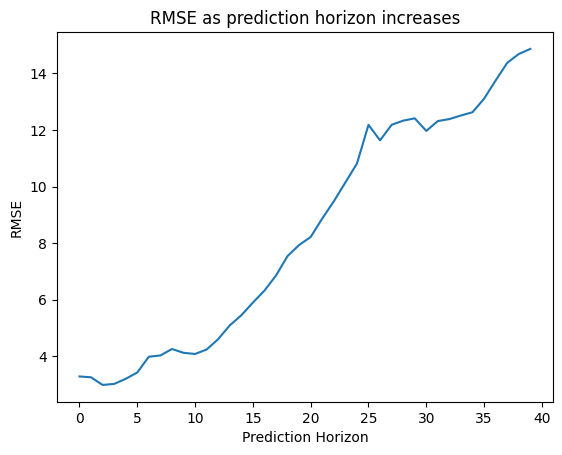

In [55]:
rmse_trajectory_8 = [item[2] for item in errors_traj_8]
plt.title("RMSE as prediction horizon increases")
plt.plot(rmse_trajectory_8)
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")

## Trajectory 9

Preintegrating IMU data (Save raw wa_xyz also)...


  0%|          | 0/1 [00:00<?, ?it/s]

=> Read IMU file: kitti/2011_09_26/2011_09_26_drive_0022_sync/matched_oxts/matched_oxts.txt


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


=> Num of filenames before filtering based on IMU nan: 40
=> Num of filenames After filtering based on IMU nan: 40
average velocity: tensor([8.5477])


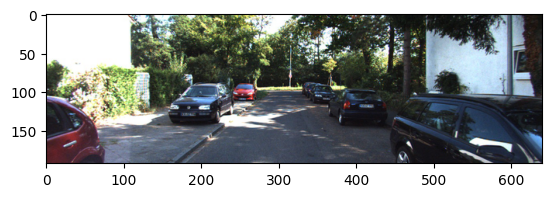

In [56]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

filtered_data = [entry for entry in train_filenames if entry.endswith(' l')]
train_filenames = sorted(filtered_data, key=extract_sort_keys)
# fraction_trajectory_5 = train_filenames[7629+2485:7629+2485+40]
# fraction_trajectory_5 = train_filenames[7629+2545:7629+2545+40]
# fraction_trajectory_5 = train_filenames[7629+7050:7629+7050+40]
# fraction_trajectory_5 = train_filenames[7629+1220:7629+1220+40]
fraction_trajectory_9 = train_filenames[1771:1771+40]
dataset_trajectory_9 = datasets.KITTIRAWDataset("kitti", fraction_trajectory_9,
                                           192, 640,
                                           [0, -1, 1], 4, use_imu=True, is_train=False)


dataloader_trajectory_9 = DataLoader(dataset_trajectory_9, 1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
list_frames_traj_9 = []
alpha, R_c, R_cbt_bc, delta_t, gravities, velocities = [], [], [], [], [], []
start_time = time.time()
avg_velocity = []
for idx,sample in enumerate(dataloader_trajectory_9):

    # Standard processing
    for key, ipt in sample.items():
            if key in [("preint_imu", -1, 0), ("preint_imu", 0, 1)]:
                for pkey, pipt in sample[key].items():
                    # inputs[key][pkey] = pipt.to(self.device).type(torch.float32)
                    sample[key][pkey] = pipt.to(device, dtype=torch.float32)
            else:
                # inputs[key] = ipt.to(self.device).type(torch.float32)
                sample[key] = ipt.to(device, dtype=torch.float32)
    
    if idx == 0:
        init_sample = sample
        init_image = sample[('color', 0, 0)]
    frames = sample[('color', 0, 0)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames
    im = ax.imshow(frame_data[0].permute(1, 2, 0).detach().numpy(), cmap='viridis')
    
    list_frames_traj_9.append(im)

    plt.close(fig)

    # Get IMU parameters
    next_imu = sample[('preint_imu',-1,0)]
    alpha.append(next_imu["alpha"])
    R_c.append(next_imu["R_c"])
    R_cbt_bc.append(next_imu["R_cbt_bc"])
    delta_t.append(next_imu["delta_t"])
    avg_velocity.append(next_imu["v_norm"])

image_frames_traj_9 = [im.get_array() for im in list_frames_traj_9]

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Initialize the image on the axis (using the first frame's shape)
im = ax.imshow(image_frames_traj_9[0], cmap='viridis')

# Update function for animation
def update(frame):
    im.set_data(frame)
    return [im]

# Create an animation
ani = animation.FuncAnimation(
    fig, update, frames=image_frames_traj_9, interval=100, blit=True
)

    # Save the animation as a video file (e.g., MP4)
ani.save('Trajectories_anim/trajectory_9.mp4', writer='ffmpeg', fps=10)

vel_9 = torch.mean(torch.stack(avg_velocity),dim=0)
print(f"average velocity: {vel_9}")

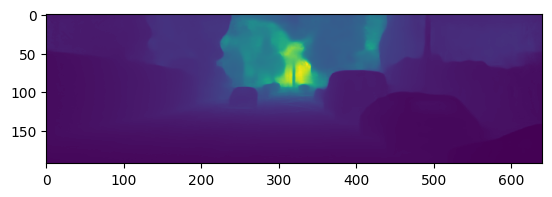

/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


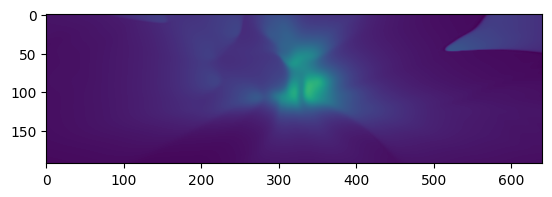

In [57]:
#depth
TRANS_SCALE_FACTOR = 5.4
pair_inputs = [init_sample[('color', 0, 0)],init_sample[('color', 1, 0)]]

# velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
velo_inputs = [models["velo_encoder"](torch.cat(pair_inputs, 1))]
# gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
gravity_inputs = [models["gravity_encoder"](torch.cat(pair_inputs, 1))]


velocity = models["velo"](velo_inputs)
gravity = models["gravity"](gravity_inputs)

R_cbt_bc[0] = R_cbt_bc[0]

# poses_trajectory_1 = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
# disp_trajectory_1 = models["depth"](models["encoder"](torch.unsqueeze(init_sample[('color', 0, 0)],dim=0)))
disp_trajectory_9 =  models["depth"](models["encoder"](init_image))
# poses_depth = get_poses_depth(poses_trajectory_1,dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
poses_depth = get_poses_depth(dataset_trajectory_9,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
depth_after_imu,depth_init_trajectory_9,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_9[("disp", 0)],poses_depth,init_sample,init_image)
# depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],diagonal_pose_with_z_translation,init_sample,init_image)


get_video_depth(depth_after_imu,"Depth_anim/depth_trajectory_9.mp4")

In [58]:
# importlib.reload(export_gt_depths_kitti_part2)

export_gt_depths_kitti_part2(fraction_trajectory_9,traj=9)


def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Read ground truth depth
gt_path = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_9_gt/gt_depths.npz"
gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

disable_median_scaling = True

errors_traj_9 = []
ratios = []
pred_depths = depth_after_imu
pred_depths = torch.stack(pred_depths,dim=0)
pred_depths = pred_depths.cpu().detach().numpy()
print(len(pred_depths))
print(len(gt_depths))
for i in range(pred_depths.shape[0]):

    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_depth = pred_depths[i]
    print(np.squeeze(pred_depth,axis=(0,1)).shape)
    pred_depth = cv2.resize(np.squeeze(pred_depth,axis=(0,1)), (gt_width, gt_height))

    mask = gt_depth > 0

    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]

    # if not opt.disable_median_scaling:
    if disable_median_scaling:
        ratio = np.median(gt_depth) / np.median(pred_depth)
        ratios.append(ratio)
        pred_depth *= ratio

    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

    errors_traj_9.append(compute_errors(gt_depth, pred_depth))

# if not opt.disable_median_scaling:
if disable_median_scaling:
    ratios = np.array(ratios)
    med = np.median(ratios)
    print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))
#     if opt.show_scale_hist:
#         pdb.set_trace()

mean_errors = np.array(errors_traj_9).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")

Saving to /Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_9_gt/gt_depths.npz
40
40
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
 Scaling ratios | med: 4.578 | std: 0.078

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.268  &   2.307  &   6.559  &   0.339  &   0.592  &   0.845  &   0.935  \\

-> Done!


Text(0, 0.5, 'RMSE')

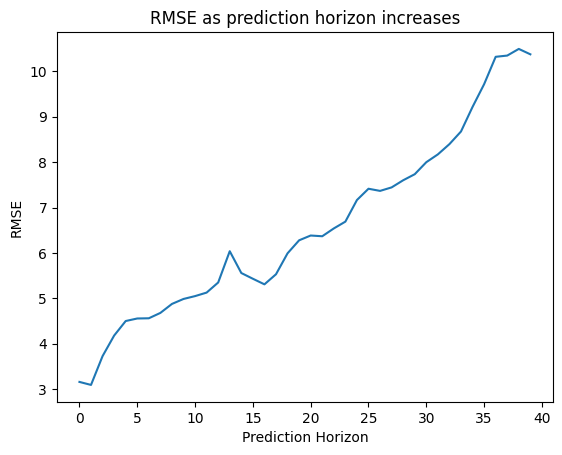

In [59]:
rmse_trajectory_9 = [item[2] for item in errors_traj_9]
plt.title("RMSE as prediction horizon increases")
plt.plot(rmse_trajectory_9)
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")

## Trajectory 10

Preintegrating IMU data (Save raw wa_xyz also)...


  0%|          | 0/1 [00:00<?, ?it/s]

=> Read IMU file: kitti/2011_09_30/2011_09_30_drive_0028_sync/matched_oxts/matched_oxts.txt


100%|██████████| 1/1 [00:05<00:00,  5.04s/it]


=> Num of filenames before filtering based on IMU nan: 40
=> Num of filenames After filtering based on IMU nan: 40
average velocity: tensor([10.4454])


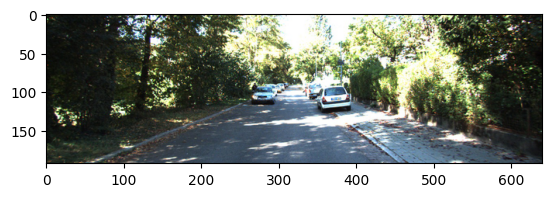

In [80]:
def extract_sort_keys(item):
    prefix, rest = item.split('_sync ')
    sync_number, side = rest.split(' ')
    return (prefix, int(sync_number), side)

filtered_data = [entry for entry in train_filenames if entry.endswith(' l')]
train_filenames = sorted(filtered_data, key=extract_sort_keys)
fraction_trajectory_10 = train_filenames[11487:11487+40]
dataset_trajectory_10 = datasets.KITTIRAWDataset("kitti", fraction_trajectory_10,
                                           192, 640,
                                           [0, -1, 1], 4, use_imu=True, is_train=False)


dataloader_trajectory_10 = DataLoader(dataset_trajectory_10, 1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
list_frames_traj_10 = []
alpha, R_c, R_cbt_bc, delta_t, gravities, velocities = [], [], [], [], [], []
start_time = time.time()
avg_velocity = []

for idx,sample in enumerate(dataloader_trajectory_10):

    # Standard processing
    for key, ipt in sample.items():
            if key in [("preint_imu", -1, 0), ("preint_imu", 0, 1)]:
                for pkey, pipt in sample[key].items():
                    # inputs[key][pkey] = pipt.to(self.device).type(torch.float32)
                    sample[key][pkey] = pipt.to(device, dtype=torch.float32)
            else:
                # inputs[key] = ipt.to(self.device).type(torch.float32)
                sample[key] = ipt.to(device, dtype=torch.float32)
    
    if idx == 0:
        init_sample = sample
        init_image = sample[('color', 0, 0)]
    frames = sample[('color', 0, 0)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create an initial frame
    frame_data = frames
    im = ax.imshow(frame_data[0].permute(1, 2, 0).detach().numpy(), cmap='viridis')
    
    list_frames_traj_10.append(im)

    plt.close(fig)

    # Get IMU parameters
    next_imu = sample[('preint_imu',-1,0)]
    alpha.append(next_imu["alpha"])
    R_c.append(next_imu["R_c"])
    R_cbt_bc.append(next_imu["R_cbt_bc"])
    delta_t.append(next_imu["delta_t"])
    avg_velocity.append(next_imu["v_norm"])

image_frames_traj_10 = [im.get_array() for im in list_frames_traj_10]

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Initialize the image on the axis (using the first frame's shape)
im = ax.imshow(image_frames_traj_10[0], cmap='viridis')

# Update function for animation
def update(frame):
    im.set_data(frame)
    return [im]

# Create an animation
ani = animation.FuncAnimation(
    fig, update, frames=image_frames_traj_10, interval=100, blit=True
)

    # Save the animation as a video file (e.g., MP4)
ani.save('Trajectories_anim/trajectory_10.mp4', writer='ffmpeg', fps=10)
vel_10 = torch.mean(torch.stack(avg_velocity),dim=0)
print(f"average velocity: {vel_10}")

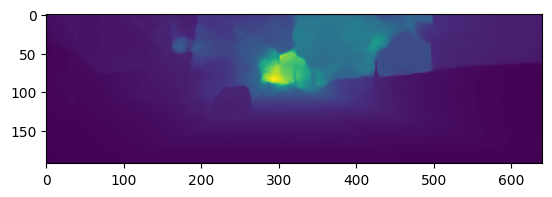

/Users/ibrahimhassan/anaconda3/envs/env_new_full/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)
(192, 640, 1)


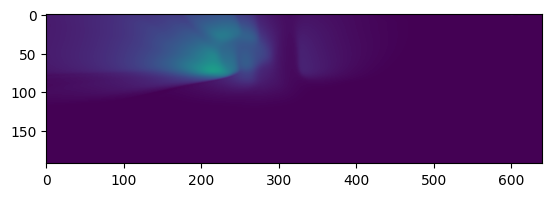

In [81]:
#depth
TRANS_SCALE_FACTOR = 5.4
pair_inputs = [init_sample[('color', 0, 0)],init_sample[('color', 1, 0)]]

# velo_inputs = [models["velo_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
velo_inputs = [models["velo_encoder"](torch.cat(pair_inputs, 1))]
# gravity_inputs = [models["gravity_encoder"](torch.unsqueeze((torch.cat(pair_inputs, 0).to(torch.float32)),dim=0))]
gravity_inputs = [models["gravity_encoder"](torch.cat(pair_inputs, 1))]


velocity = models["velo"](velo_inputs)
gravity = models["gravity"](gravity_inputs)

R_cbt_bc[0] = R_cbt_bc[0]

# poses_trajectory_1 = compute_imu_pose_with_inv(alpha, R_c, R_cbt_bc, delta_t, gravity, velocity, TRANS_SCALE_FACTOR)
# disp_trajectory_1 = models["depth"](models["encoder"](torch.unsqueeze(init_sample[('color', 0, 0)],dim=0)))
disp_trajectory_10 =  models["depth"](models["encoder"](init_image))
# poses_depth = get_poses_depth(poses_trajectory_1,dataset_trajectory_1,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
poses_depth = get_poses_depth(dataset_trajectory_10,models,alpha,R_c,R_cbt_bc,delta_t,TRANS_SCALE_FACTOR)
depth_after_imu,depth_init_trajectory_10,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_10[("disp", 0)],poses_depth,init_sample,init_image)
# depth_after_imu,depth_init_trajectory_1,images_after_imu = get_depth_trajectory(batch_size,disp_trajectory_1[("disp", 0)],diagonal_pose_with_z_translation,init_sample,init_image)


get_video_depth(depth_after_imu,"Depth_anim/depth_trajectory_10.mp4")

In [82]:
# importlib.reload(export_gt_depths_kitti_part2)

export_gt_depths_kitti_part2(fraction_trajectory_10,traj=10)


def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Read ground truth depth
gt_path = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_10_gt/gt_depths.npz"
gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

disable_median_scaling = True

errors_traj_10 = []
ratios = []
pred_depths = depth_after_imu
pred_depths = torch.stack(pred_depths,dim=0)
pred_depths = pred_depths.cpu().detach().numpy()
print(len(pred_depths))
print(len(gt_depths))
for i in range(pred_depths.shape[0]):

    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_depth = pred_depths[i]
    print(np.squeeze(pred_depth,axis=(0,1)).shape)
    pred_depth = cv2.resize(np.squeeze(pred_depth,axis=(0,1)), (gt_width, gt_height))

   
    mask = gt_depth > 0

    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]

    # if not opt.disable_median_scaling:
    if disable_median_scaling:
        ratio = np.median(gt_depth) / np.median(pred_depth)
        ratios.append(ratio)
        pred_depth *= ratio

    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

    errors_traj_10.append(compute_errors(gt_depth, pred_depth))

# if not opt.disable_median_scaling:
if disable_median_scaling:
    ratios = np.array(ratios)
    med = np.median(ratios)
    print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))
#     if opt.show_scale_hist:
#         pdb.set_trace()

mean_errors = np.array(errors_traj_10).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")



Saving to /Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/Part2/Traj_10_gt/gt_depths.npz
40
40
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
(192, 640)
 Scaling ratios | med: 6.844 | std: 0.546

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.281  &   4.548  &   7.956  &   0.358  &   0.693  &   0.841  &   0.905  \\

-> Done!


Text(0, 0.5, 'RMSE')

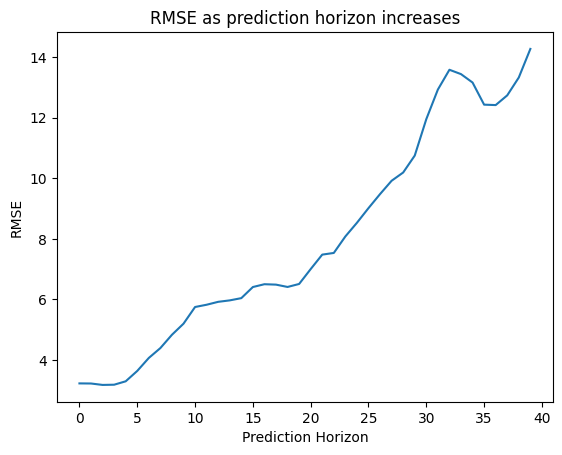

In [83]:
rmse_trajectory_10 = [item[2] for item in errors_traj_10]
plt.title("RMSE as prediction horizon increases")
plt.plot(rmse_trajectory_10)
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")

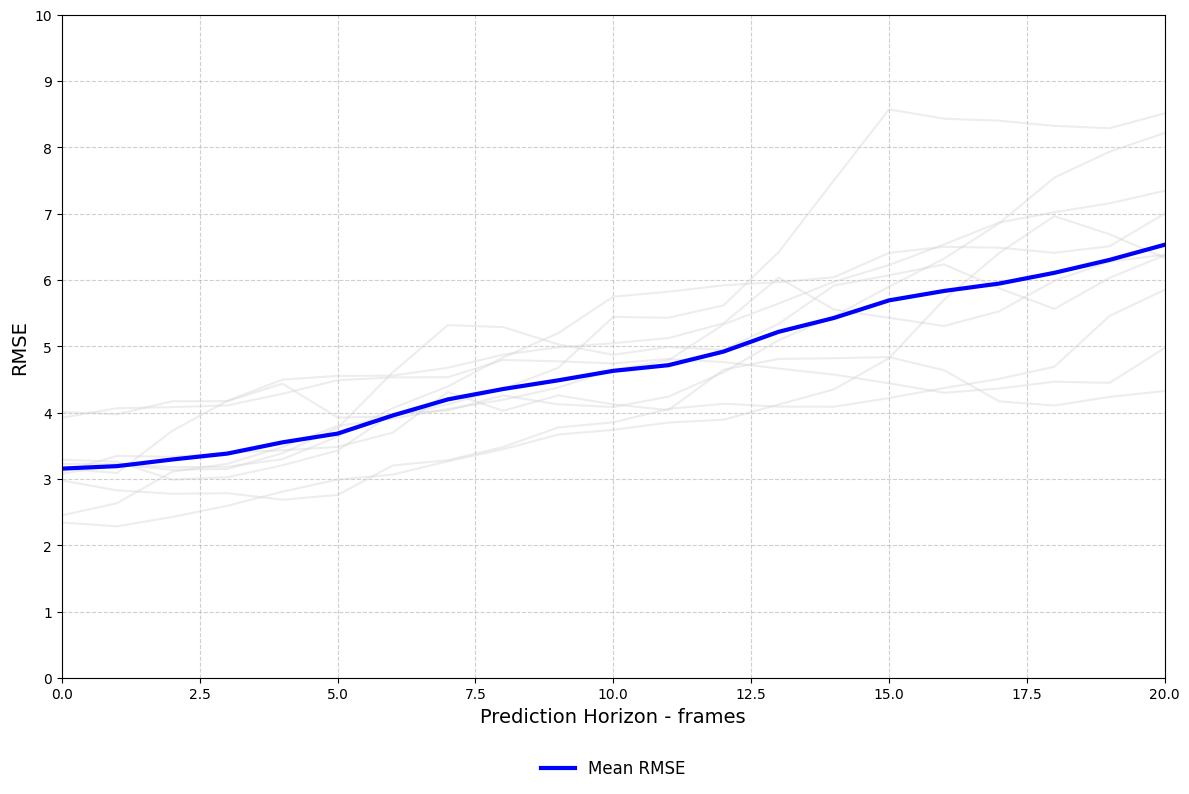

In [134]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# Assuming your RMSE trajectories are numpy arrays or lists of length 20
# Replace with your actual RMSE data and velocities
rmse_trajectories = [
    rmse_trajectory_1, rmse_trajectory_2, rmse_trajectory_3,
    rmse_trajectory_4, rmse_trajectory_5, rmse_trajectory_6,
    rmse_trajectory_7, rmse_trajectory_8, rmse_trajectory_9,
    rmse_trajectory_10
]

velocities = [
    torch.round(vel_1[0]), torch.round(vel_2[0]), torch.round(vel_3[0]),
    torch.round(vel_4[0]), torch.round(vel_5[0]), torch.round(vel_6[0]),
    torch.round(vel_7[0]), torch.round(vel_8[0]), torch.round(vel_9[0]),
    torch.round(vel_10[0])
]

# Compute mean RMSE across all trajectories
mean_rmse = np.mean(rmse_trajectories, axis=0)

# Prepare data for SVR
X = np.arange(len(mean_rmse)).reshape(-1, 1)  # Prediction horizon frames (0, 1, ..., 19)
y = mean_rmse  # Mean RMSE values

# Fit SVR model with RBF kernel
svr_model = SVR(kernel='rbf', C=1e3, gamma=0.1)  # You can tune C and gamma for better performance
svr_model.fit(X, y)

# Predict RMSE values using the SVR model
y_svr_pred = svr_model.predict(X)

# Plot original trajectories
plt.figure(figsize=(12, 8))
# plt.title("Forecast Horizon IMU Depth Map Generation", fontsize=16)

for idx, (traj, velocity) in enumerate(zip(rmse_trajectories, velocities), 1):
    plt.plot(traj, color='lightgrey', alpha=0.4)  # Increase transparency to make it less prominent
    # Annotate the start of each trajectory with its velocity
    # plt.text(0, traj[0], f'v={velocity:.1f} m/s', fontsize=9, color='black', alpha=0.7)

# Plot the mean RMSE
plt.plot(mean_rmse, label='Mean RMSE', color='blue', linewidth=3)

# # Plot the best-fit line (SVR nonlinear regression)
# plt.plot(X, y_svr_pred, label='Best Fit Line (SVR, RBF Kernel)', color='red', linestyle='-', linewidth=3)

plt.xlabel("Prediction Horizon - frames", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.ylim(0, 10)
plt.xlim(0, 20)

y_ticks = np.linspace(0, 10, 11)  # 11 ticks from 0 to 10 (e.g., [0, 1, 2, ..., 10])
plt.yticks(y_ticks)

# Add a cleaner legend and place it outside the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12, frameon=False)

# Add gridlines for better readability
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Show the final improved plot
plt.tight_layout()
plt.show()
